# Data Science Project

## Purpose
The goal of this data science project is to compute the Soil Organic Carbon (SOC) stock change by land cover class within a given region. The project will be implemented using a project-based learning approach, gradually buildind a Streamlit application as the final deliverable. The application will provide an interface to visualize and analyze the SOC stock change based on land cover types.

## Methodology
The steps to follow are described in the [Data Science Project repo](https://github.com/Vizzuality/sci_team_data_bank/wiki/Data-Science-Project).

## Setup
### Library import
We import all the required Python libraries

In [1]:
import sys

import ee

from color_palettes import landcover_info, sld_ramp, soc_color_ramp
from utils import GeometryDrawer, LandcoverAnalyzer, MapRenderer

sys.path.append("../src")  # Add the 'src' folder to the sys.path

### Autenticate and Initialize Earth Engine

In [2]:
# ee.Authenticate()
ee.Initialize()

### Download the data from the [original source](http://maps.elie.ucl.ac.be/CCI/viewer/), convert NETCDF into GeoTIFF and upload it to Google Earth Engine

This only needs to be done once. And **note** that method upload_to_gee doesn't work because we can't upload files from local to GEE, they have to be stored in a bucket in Google Cloud Storage. Thus, we need to upload them manually. 


In [ ]:
# input_nc_files = [
#     "/Users/sofia/Documents/Repos/SciVizz_project/data/raw/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc", # noqa: E501
#     "/Users/sofia/Documents/Repos/SciVizz_project/data/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.nc" # noqa: E501
# ]
# output_tif_files = [
#     "/Users/sofia/Documents/Repos/SciVizz_project/data/processed/landcover2000.tif",
#     "/Users/sofia/Documents/Repos/SciVizz_project/data/processed/landcover2018.tif"
# ]

# # Convert the NetCDF files to GeoTIFF
# data_processor = LandcoverDataProcessor(input_nc_files, output_tif_files)
# data_processor.convert_nc_to_tif()

# # Create a collection in GEE and upload the GeoTIFF files
# collection_path = "projects/ee-sofiaaldabet-training/assets/landcover"
# data_processor.create_gee_collection(collection_path)
# data_processor.upload_to_gee()

## Processing

### Display the map 

> #### 1. Calculate SOC stock change and visualize it together with the land cover layers for 2000 and 2018. 

> #### 2. Include the functionality to draw custom geometries on the map for further analysis.

In [3]:
# Create instances of MapRenderer, GeometryDrawer, and LandcoverAnalyzer
map_renderer = MapRenderer(center=(42, -8), zoom=7)
geometry_drawer = GeometryDrawer(map_renderer)
landcover_analyzer = LandcoverAnalyzer(map_renderer)

# Load the GEE layers
soc_stock_collection = ee.ImageCollection("projects/soils-revealed/Recent/SOC_stock_nov2020")
lc1 = ee.Image(
    ee.ImageCollection("projects/ee-sofiaaldabet-training/assets/landcover")
    .filterDate("2000-01-01", "2000-12-31")
    .first()
)  # noqa: E501
lc2 = ee.Image(
    ee.ImageCollection("projects/ee-sofiaaldabet-training/assets/landcover")
    .filterDate("2018-01-01", "2018-12-31")
    .first()
)

# Calculate the SOC stock change
sorted_collection = soc_stock_collection.sort("system:time_start")
first_image = sorted_collection.first()
last_image = sorted_collection.sort("system:time_start", False).first()
soc_stock_change = last_image.subtract(
    first_image
)  # Calculate the difference between the first and last images

# Define the visualization parameters for SOC stock change
soc_vis_params = {"min": -10, "max": 10, "palette": soc_color_ramp}

# Add the layers to the map
map_renderer.add_tile_layer(
    soc_stock_change, soc_vis_params, name="SOC Stock Change"
)  # SOC stock change using soc_color_ramp
map_renderer.add_tile_layer(
    lc1, None, sld_ramp, name="Landcover 2000"
)  # Land cover 2000 using sld_ramp
map_renderer.add_tile_layer(
    lc2, None, sld_ramp, name="Landcover 2018"
)  # Land cover 2018 using sld_ramp

# Display the map
map_renderer.display()

Map(center=[42, -8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Calculate statistics for an Area Of Interest (AOI):

>#### 1. Define the AOI or AOIs on the map
>#### 2. Calculate the % for each landcover in the AOI
>#### 3. Visualize the results in a chart

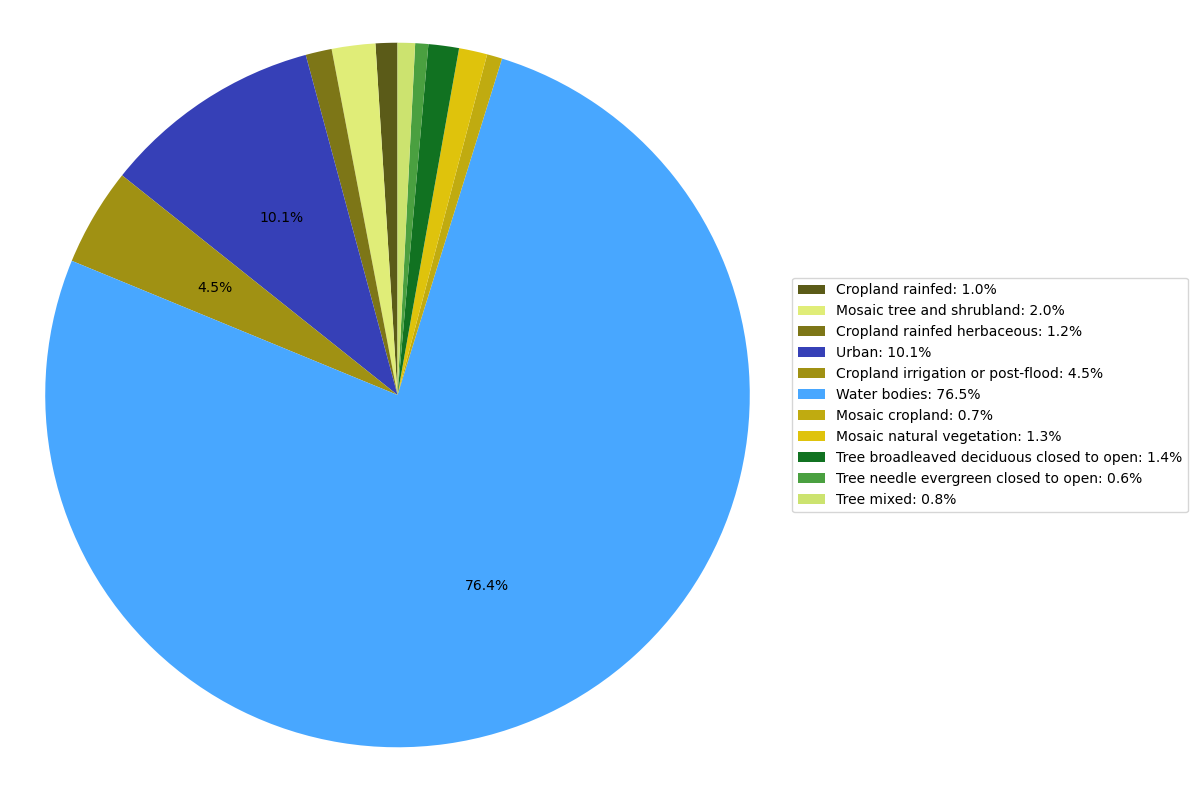

In [4]:
# Analyze land cover using the LandcoverAnalyzer
result_df = landcover_analyzer.analyze_landcover(
    image_collection="projects/ee-sofiaaldabet-training/assets/landcover",
    start_date="2018-01-01",
    end_date="2018-12-31",
    landcover_info=landcover_info,
    geometries=geometry_drawer.get_drawn_geometries(),
)
# Display the result in a pie chart
landcover_analyzer.plot_landcover_pie_chart(result_df)